In [1]:
import os
import sys
import json
import shutil
import numpy as np
import pandas as pd
from pprint import pprint
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def create_annotation_df(data_dir):
    confirmed_count = 0
    keys = ['filename', 'path','in_game',
            "spectator",
            "flying",
            "knockdown",
            "eliminated",
            "downed",
            "pre_game",
            "gulag",
            "death",
            "lobby",
            "start_game",
            "menu",
            "plunder",
            "kill_cam",
            "reviving",
            "rebirth_counter",
            "lost",
            "victory"]
    
    data_dict = {key: [] for key in keys}
    for root, _, fnames in os.walk(data_dir):
        for fname in fnames:
            if fname[-5:] == ".json":
                annot = json.load(open(os.path.join(root, fname)))
               
                confirmed = annot.get('confirmed', False)
                
                if confirmed < 1:
                    confirmed_count+=1
                    continue
                
                    
                for k, v in annot.items():
                    if k not in keys:
                        continue
                    data_dict[k].append(v)
    df= pd.DataFrame.from_dict(data_dict)
    print(confirmed_count)
    return df

In [3]:
df = create_annotation_df('/media/jakeshomer/86c3d6b9-68df-4442-81fe-658d67ddcb911/warzone/scene_detector/s3_spectator/')

0


In [5]:
def copy_images_for_training(df):
    root = '/media/jakeshomer/86c3d6b9-68df-4442-81fe-658d67ddcb911/warzone/scene_detector/current_training_data/images'
    count = 0
    for i, row in df.iterrows():
        fname = row.filename
        path = row.path
        if not os.path.isfile(os.path.join(root, fname)):
            count += 1
            shutil.copy(os.path.join(path, fname), os.path.join(root, fname))
    print(f'Coppied {count} images')
    print("Done!")

In [6]:
copy_images_for_training(df)

Coppied 1152 images
Done!


In [9]:
def train_test_split_df(df, pct=0.05):
    keys = ['in_game',
            "spectator",
            "flying",
            "knockdown",
            "eliminated",
            "downed",
            "pre_game",
            "gulag",
            "death",
            "lobby",
            "start_game",
            "menu",
            "plunder",
            "kill_cam",
            "reviving",
            "rebirth_counter",
            "lost",
            "victory"]
    if type(df) == str:
        df = pd.read_pickle(df)
    
    test_idx = []
    
    for key in keys:
        _df = df[df[key] == 1]
        indecies = _df.index
        num_samples = int(indecies.shape[0]*pct)
        idxs = np.random.choice(indecies, num_samples, replace=False)
        test_idx.extend(idxs.tolist())
        
    test_idx = list(set(test_idx))
        
        
    negative = df[(df[keys] == 0).all(axis=1)]
    neg_idxs = negative.index
    num_samples = int(neg_idxs.shape[0]*pct)
    idxs = np.random.choice(neg_idxs, num_samples, replace=False)
    test_idx.extend(idxs.tolist())
    test_idx = set(test_idx)
    train_idx = [idx for idx in df.index if idx not in test_idx]
    test_df = df.loc[test_idx]
    train_df = df.loc[train_idx]
    
    return train_df, test_df
        

In [10]:
train_df, test_df = train_test_split_df(df)

In [18]:
old_train = pd.read_pickle('/media/jakeshomer/86c3d6b9-68df-4442-81fe-658d67ddcb911/warzone/scene_detector/current_training_data/test_data_v4.pkl')

In [19]:
x = pd.concat([test_df, old_train])

In [20]:
x.shape

(2705, 20)

In [21]:
x.to_pickle('/media/jakeshomer/86c3d6b9-68df-4442-81fe-658d67ddcb911/warzone/scene_detector/current_training_data/test_data_v5.pkl')

In [2]:
def convert_img(img, normalize=True):
    img = img.numpy()
    img = np.transpose(img, (1,2,0))
    
    if normalize:
        mean = np.array([
        0.2994,
        0.3169,
        0.3274
      ], dtype=np.float32)
        std = np.array([
        0.1901,
        0.196,
        0.206
      ], dtype=np.float32)
        img = (img *std) + mean
    img = img*255
    return img.astype(np.uint8)

In [10]:
from dataset import *

In [11]:
config = json.load(open('config_files/config.json'))

In [12]:
data = WZDataset(True, config)

******************************
Train Dataset
{'death': 140,
 'downed': 328,
 'flying': 1128,
 'gulag': 825,
 'in_game': 11428,
 'kill_cam': 228,
 'lobby': 812,
 'lost': 106,
 'menu': 369,
 'negative': 1437,
 'pre_game': 1283,
 'rebirth_counter': 164,
 'reviving': 69,
 'spectator': 1764,
 'start_game': 290}
******************************


In [13]:
data.class_mapping

{'death': 0,
 'downed': 1,
 'flying': 2,
 'gulag': 3,
 'in_game': 4,
 'kill_cam': 5,
 'lobby': 6,
 'lost': 7,
 'menu': 8,
 'pre_game': 9,
 'rebirth_counter': 10,
 'reviving': 11,
 'spectator': 12,
 'start_game': 13}

11704
['in_game']


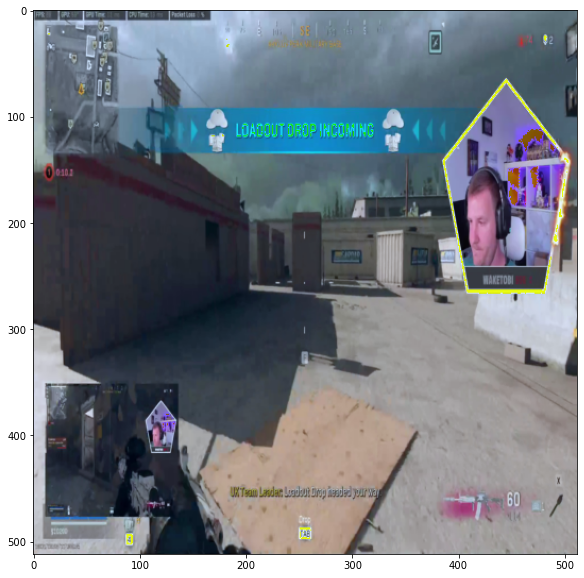

In [18]:
idx = np.random.randint(0, len(data))
print(idx)
img, t = data[idx]
fig = plt.figure(figsize=(10,10))
plt.imshow(convert_img(img))
target = [mapping[i] for i, cls in enumerate(t) if cls == 1]
print(target)